<h2>Reinforcement learning</h2>
<h3>Introduction</h3>
<p>Reinforcement learning is a part of machine learning where agents learns to perform actions in an environment to maximize a reward. The important components are agent and environment. Agent represents the learning algorithm and environment represents the problem to be solved. The agent and environment continously interact with each other.</p>
<img src="https://www.tensorflow.org/agents/tutorials/images/rl_overview.png" width='1050' height='450'><br>
<p>In this notebook we show how to train a <b>REINFORCE</b> agent on the <b>cartpole</b> environment using the <b>TF-Agents</b> library. We will walk through all the components in a reinforcement learning pipeline for training, evaluation and data collection.</p>

In [1]:
#Installing required libraries which are not there in notebook
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf_agents
!pip install -q tf-agents-nightly
!pip install -q tf-nightly


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [60.5 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://security.ubuntu.com/ubu

In [2]:
#Import required libraries
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()


# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

<h3>Hyperparameter</h3>
<p>We define some of the hyperparameters required for the model we are training.</p>

In [3]:
env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 250 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

<h3>Environment</h3>
<p>Environment is the component of RL, it represents the task or problem that we are trying to solve. Stabdard environments can be easily created in TF-Agents using <b>suites</b>. There are different suits loading the environments from open sources(Example OpenAI Gym, Atari), given a string environment name. We are loading the Cartpole environment from the OpenAI Gym suite.</p>

In [4]:
# Loading the environment env_name which is defined in hyperparameter section  
env = suite_gym.load(env_name)

<p>We can show this cartpole environment using PIL library. It is a free-swinging pole is attached to a cart. The goal is to move the cart right or left in order to keep the pole pointing up.</p>

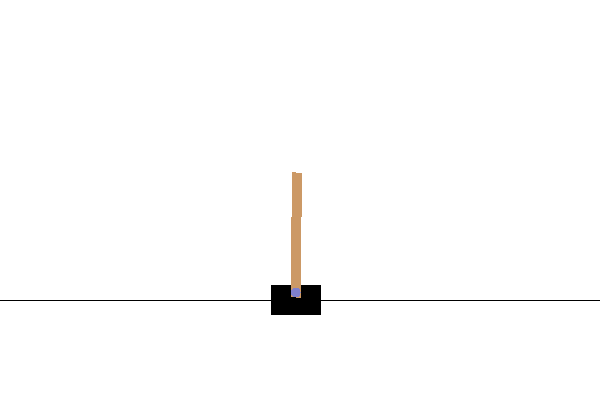

In [5]:
env.reset()

#Rendering the cartpole environment
PIL.Image.fromarray(env.render())

<p>The statement <b>time_step = environment.step(action)</b> wil takes action in the environment. The <b>Time_step</b> tuple returns the environment's next observation and reward for that action.<br>
The methods <b>time_step_spec()</b> and <b>action_spec()</b> in the environment will return the specifications like type, shape and bounds of the time step and actions respectively.</p>


In [6]:
#Printing the specifications of time step and action
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


<p>Next we see that observation, which is an array of 4 float values. They are position and velocity of the cart and the angular position and velocity of the pole. Since there are only two actions, moving left and right. The action_spec is a scalar where 0 means moving left and 1 means moving right.</p>

In [7]:
# Displaying the time step of now
time_step = env.reset()
print('Time step:')
print(time_step)

# Defining the action using numpy array
action = np.array(1, dtype=np.int32)

#Defining next step for environment by passing action
next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.02700736,  0.00599337,  0.03145964, -0.04018597], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.0268875 ,  0.2006504 ,  0.03065592, -0.32277942], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


<p>We create two environments: one for training and another for evaluation. Most of all the environments are written in Python. We will converted to TensorFlow by wrapping it using <b>TFPyEnvironment</b> wrapper. The original environment API uses numpy arrays, the TFPyEnvironment convert these to/from Tensors for easily interaction with the TensorFlow policies and agents.</p>

In [8]:
# Create the environment for training evaluation using open AI gym
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

#Convert environment to Tensor by using TFPyEnvironment
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

<h3>Agent</h3>
<p>Agent is the algorithm used to solve a Reinforcement learning. In addition to the REINFORCE agent (which we use), TF-Agents provides DQN, DDPG, TD3, PPO and SAC agents. These are standard implementation of agents. To create a REINFORCE agent, we need to create <b>Actor Nrtwork </b> first, that can learn to predict the action given an observation from the environment. <br>
The Actor Network can be easily created using the specs of the observations and actions. We can specify the layers in the network, in our example, it is fc_layer_params argument set to a tuple of ints representing the sizes of each hidden layer (sizes are represented in hyperparameter section).</p>

In [9]:
# Defining the actor network for predicting the action
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

<p>We also need an <b>optimizer</b> to train the network (we just create), and also a <b>train_step_counter</b> variable to keep track of how many times the network was updated.</p>

In [10]:
# Defining an adam optimizer of keras
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

#Train step counter for keep track of network updation
train_step_counter = tf.compat.v2.Variable(0)

#Defining the agent with all required parameters which are defined above section
tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)

#Initializing the agent
tf_agent.initialize()

<h3>Policies</h3>
<p>In TF-Agents, policies represent the standard notion of policies in RL: given a time_step produce an action or a distribution over actions. The main method <b>policy_step = policy.action(time_step)</b> where policy_step is a named tuple <b>PolicyStep(action, state, info)</b>. The <b>policy_step.action</b> is the action to be applied to the environment, <b>state</b> represents the state of stateful (RNN) policies and <b>info</b> contain information such as log probabilities of the actions. <br>
The agents contains two policies, The main policy is used for evaluation/deployment and another policy is used for data collection.</p> 

In [11]:
#Defining the main policy
eval_policy = tf_agent.policy

#Policy for data collection
collect_policy = tf_agent.collect_policy

<h3>Metrics and Evaluation</h3>
<p>The most common metric used to evaluate the policy is the <b>average return</b>. The return is the sum of rewards obtained while running a policy in an environment for an episode and we average this over a few episodes. We compute the average return metric as follows.</p>

In [12]:
# Defining the function to return average return metric
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# Please also see the metrics module for standard implementations of different
# metrics.

<h4>Replay Buffer</h4>
<p>The data collected from the environment can be tracked using <b>TFUniformReplayBuffer</b>. This replay buffer is constructed using specs describing the tensors which are to be stored and can be obtained from the agent using <b>tf_agent.collect_data_spec</b>.</p>

In [13]:
#Defining the replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

<p>For most of the agents, the <b>collect_data_spec </b> is a <b>Trajectory</b> named tuple containing the observation, action, reward etc.</p> 

<h3>Data Collection</h3>
<p>The REINFORCE agent learns from whole episodes. So, we define a function to collect an episode using the given data collection policy and save the data such as observations, rewards etc. as trajectories in the replay buffer (defined in the previous section). </p>

In [14]:
# Defining the function to collect the episodes using environment, policy, number of episodes
def collect_episode(environment, policy, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1


# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

<h3>Training the agent</h3>
<p>The training loop involves both collecting data from the environment and optimizing the agent's networks. Alog with that, we will occasionally evaluate the agent's policy to see how we are doing. The training will take around 3 minutes to run. </p>

In [15]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
step = 25: loss = -0.18207430839538574
step = 50: loss = 0.28838586807250977
step = 50: Average Return = 130.1999969482422
step = 75: loss = -1.847233533859253
step = 100: loss = -0.6875426769256592
step = 100: Average Return = 104.0
step = 125: loss = -1.2449371814727783
step = 150: loss = -0.25373631715774536
step = 150: Average Return = 153.10000610351562
step = 175: loss = 0.40825700759887695
step = 200: loss = -4.019901275634766
step = 200: Average Return = 200.0
step = 225: loss = 0.7915764451026917
step = 250: loss = 0.5942778587341309
step = 250: Average Return = 200.0


<h3>Plotting </h3>
<p>We can plot return vs global steps to see the performance of REINFORCE agent. In Cartpole-v0, the environment gives a reward of +1 for every time step of +1 for every time step the pole stays up and since the maximum number of step is 200, the maximum possible return is also 200.</p>

(17.719999599456784, 250.0)

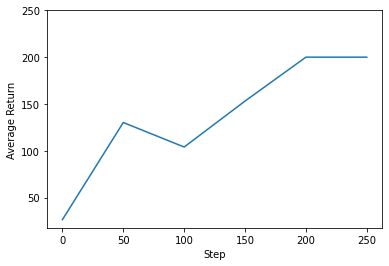

In [16]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)